# Desafio P&D (Machine Learning) Intelivix

O objetivo do desafio é fazer identificação de sentimentos utilizando textos extraídos de reviews de filmes através de técnicas de machine learning. Mais precisamente, o problema consiste na criação de um modelo preditivo de classificação (5 classes: Negativo, Ligeiramente Negativo, Neutro, Ligeiramente Positivo, Positivo) de análise de polaridade de sentimentos baseado em frases. 

Esse notebook tem a seguinte estrutura. Primeiramente é feito o carregamento dos dados e verificação de erros na operação. Depois esses dados são explorados a fim de se obter informações de como proceder na fase de modelagem. Na terceira parte temos o treinamento dos 3 modelos. Após isso é feita a análise dos resultados. E por último temos as conclusões finais.

In [1]:
import re
import nltk
import random
import warnings
import itertools

import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from joblib           import dump, load
from pathlib          import Path
from collections      import Counter
from nltk.tokenize    import word_tokenize
from nltk.stem        import WordNetLemmatizer
from yellowbrick.text import FreqDistVisualizer

from sklearn.pipeline                import Pipeline
from sklearn.ensemble                import RandomForestClassifier
from sklearn.linear_model            import LogisticRegression
from sklearn.model_selection         import train_test_split,  GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from sklearn.metrics                 import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.naive_bayes             import MultinomialNB

# Evaluating on Test Set
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning) 

In [2]:
# Project folders main paths
THISPATH   = Path().absolute()
DATAPATH   = THISPATH / "data" 
RAWPATH    = DATAPATH / "raw"       # raw data
REPORTPATH = THISPATH / "reports"

# Setting random state for experiment reproducibility
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Downloading nlkt packages used in the project
nltk.download(['punkt', 'wordnet'])

[nltk_data] Downloading package punkt to C:\Users\Gabriel
[nltk_data]     Lima\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Gabriel
[nltk_data]     Lima\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Carregamento dos dados e verificação de erros

Os dados utilizados se econtram no arquivo "train.tsv". Esse arquivo consiste em uma tabela delimitada por tabs contendo 156060 entradas dispostas em 4 colunas de variáveis como descritas a seguir:

* __Id:__ Identificador único da frase
* __IdSentenca:__ Identificador da sentença original que origina a frase
* __Texto:__ Frase a ser analisada
* __Sentimento:__ Sentimento relacionado a frase (ou seja, a classe do problema)

In [3]:
reviews_df = pd.read_table(RAWPATH/"train.tsv")

Após o carregamento é importante verificar alguns erros comuns relacionadas a operalção, isto é, colunas fora do lugar, linhas não carregadas corretamente, entre outros.

In [4]:
reviews_df.shape

(156060, 4)

In [5]:
reviews_df.dtypes

Id             int64
IdSentenca     int64
Texto         object
Sentimento     int64
dtype: object

Observando o codigo acima é possível observar que as linhas e colunas aparentemente foram carregadas corretamente já que as dimensões e os tipos de dados batem. A ideía por trás da analise do tipo das colunas é que caso algum elemento de texto fosse deslocado para uma das outras colunas o tipo de dado acusaria uma coluna do tipo "object".

In [6]:
reviews_df.isna().sum()

Id            0
IdSentenca    0
Texto         0
Sentimento    0
dtype: int64

Outra verificação possível é a de missing values, que neste caso pode mostrar erros de deslocamento de elementos nas colunas. Como pode ser visto não há nenhum problema aparente.

Além disso, visualizar alguns elementos da tabela podem ajudar não só na descoberta de erros, mas no entendimento dos dados. Nas linhas abaixo são feitas as verificações dos 5 elementos aleatórios, do topo e do final da tabela.

In [7]:
reviews_df.head()

,Id,IdSentenca,Texto,Sentimento
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
reviews_df.sample(5)

,Id,IdSentenca,Texto,Sentimento
95722,95723,5000,'s as sorry,2
147312,147313,8016,Romantic comedy and Dogme 95 filmmaking may se...,4
36991,36992,1752,of these days,2
150211,150212,8182,flinch from its unsettling prognosis,2
140655,140656,7631,are clinically depressed,1


In [9]:
reviews_df.tail()

,Id,IdSentenca,Texto,Sentimento
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2
156059,156060,8544,chortles,2


Para simplicar o trabalho nas etapas posteriores, as colunas Id e IdSentença são transformadas em identificadores da tabela dos dados. Além disso as variáveis passam a ter nomes minúsculos como padrão para evitar problemas de case.

In [4]:
reviews_df = reviews_df.rename(columns = {"Id": "id", "IdSentenca" : "id_sentence", "Texto": "text", "Sentimento": "sentiment"})
reviews_df = reviews_df.set_index(["id", "id_sentence"])
reviews_df.head(2)

,,text,sentiment
id,id_sentence,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2


# Análise Exploratória

Nesse passo é feita uma análise exploratória das frases dos banco de dados. O objetivo é encontrar a melhor forma de proceder nas etapas seguintes de pré-processamento e modelagem. Para facilitar essa parte os dados foram divididos em tabelas de acordo com suas classes.

In [11]:
class0_corpus = reviews_df.query("sentiment == 0")
class1_corpus = reviews_df.query("sentiment == 1")
class2_corpus = reviews_df.query("sentiment == 2")
class3_corpus = reviews_df.query("sentiment == 3")
class4_corpus = reviews_df.query("sentiment == 4")

### Desbalanceamento

Desbalancamento das classes é algo que em geral dificulta a performance dos algoritmos. Isso ocorre porque muitos algoritmos assumem igualdade na distribuição das classes e em caso de desbalanceamento isso pode favorecer a performance das classes majoritárias. Muitas técnicas e algoritmos podem ser utilizados para resolver esse problema.

Fazendo uma análise da distribuição temos:

The distributions of the classes are: 
{1: '27273 (17.5%)', 2: '79582 (51.0%)', 3: '32927 (21.1%)', 4: '9206 (5.9%)', 0: '7072 (4.5%)'}


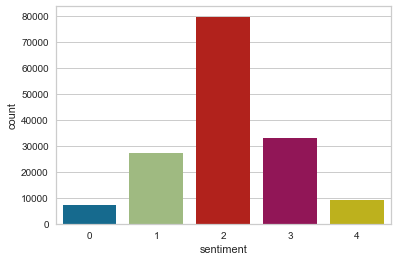

In [12]:
unbalance_count = dict(Counter(reviews_df.sentiment))
unbalance_count = {key:str(value) + " (" + str(round(value/sum(dict(unbalance_count).values())*100, 1)) + "%)" for (key,value) in unbalance_count.items()}

print("The distributions of the classes are: ")
print(unbalance_count)
sns.countplot(x="sentiment", data=reviews_df)

Como pode ser observado, temos um alto grau de desbalancamento favorecendo a classe neutra (vermelha - 2) que representa mais da metade das frases do banco de dados. Além disso, quanto mais extremo o tipo de sentimento menor a presença de frases.

### Frases e Sentenças

Cada frase representa um conjunto de palavras e símbolos. Nesse caso é importante tentar quantificar a distribuição dessas palavras para tentar obtewr alguma informação adicional. Fazendo uma análise manual dos dados é possível fazer algumas observações importantes:

* Cada frase é composta por partes de uma sentença original e apresentam palavras e símbolos repetidos entre elas.
* Existem muitas frases pequenas (com até uma palavra)
* Muitas dessas palavras são stop words, ou seja, palavras comuns que em geral não ajudam a diferenciar documentos (e.g. "it's", "to", "the")
* Pontuação pode ser o diferencial entre duas classes
* Frases da mesma sentença em geral apresentam classes diferentes

Abaixo há alguns exemplos dos pontos citados:

In [13]:
reviews_df.loc[[63, 77,78, 80, 81, 93, 99]]

,,text,sentiment
id,id_sentence,,
63,1,.,2
77,2,is worth seeking .,3
78,2,is worth seeking,4
80,2,worth,2
81,2,seeking,2
93,3,'s,2
99,3,I,2


#### Quantidade de palavras x frases

Para entender melhor algum dos pontos acima, primeiramente é feita a distribuição da quantidade de palavras por frase em relação ao conjunto inteiro e entre as classes

In [14]:
count_phrase_words = lambda df: df.text.apply(lambda x: len(x.split(" ")))

phrase_word_count = count_phrase_words(reviews_df)

class0_word_count = count_phrase_words(class0_corpus)
class1_word_count = count_phrase_words(class1_corpus)
class2_word_count = count_phrase_words(class2_corpus)
class3_word_count = count_phrase_words(class3_corpus)
class4_word_count = count_phrase_words(class4_corpus)

pd.concat([phrase_word_count.describe(), class0_word_count.describe(), class1_word_count.describe(), class2_word_count.describe(), class3_word_count.describe(), class4_word_count.describe()], 
           axis=1, keys=["total", "class0", "class1", "class2", "class3", "class4"]).round(decimals=2)

,total,class0,class1,class2,class3,class4
count,156060.00,7072.00,27273.00,79582.00,32927.00,9206.00
mean,7.20,12.11,9.11,5.19,8.45,10.70
std,7.02,8.76,7.61,5.35,7.57,8.49
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,5.00,3.00,2.00,3.00,4.00
50%,5.00,10.00,7.00,3.00,6.00,8.00
75%,10.00,17.00,13.00,6.00,11.00,15.00
max,52.00,52.00,51.00,51.00,51.00,52.00


C:\Miniconda3\envs\desafiointelivix\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Class 4')

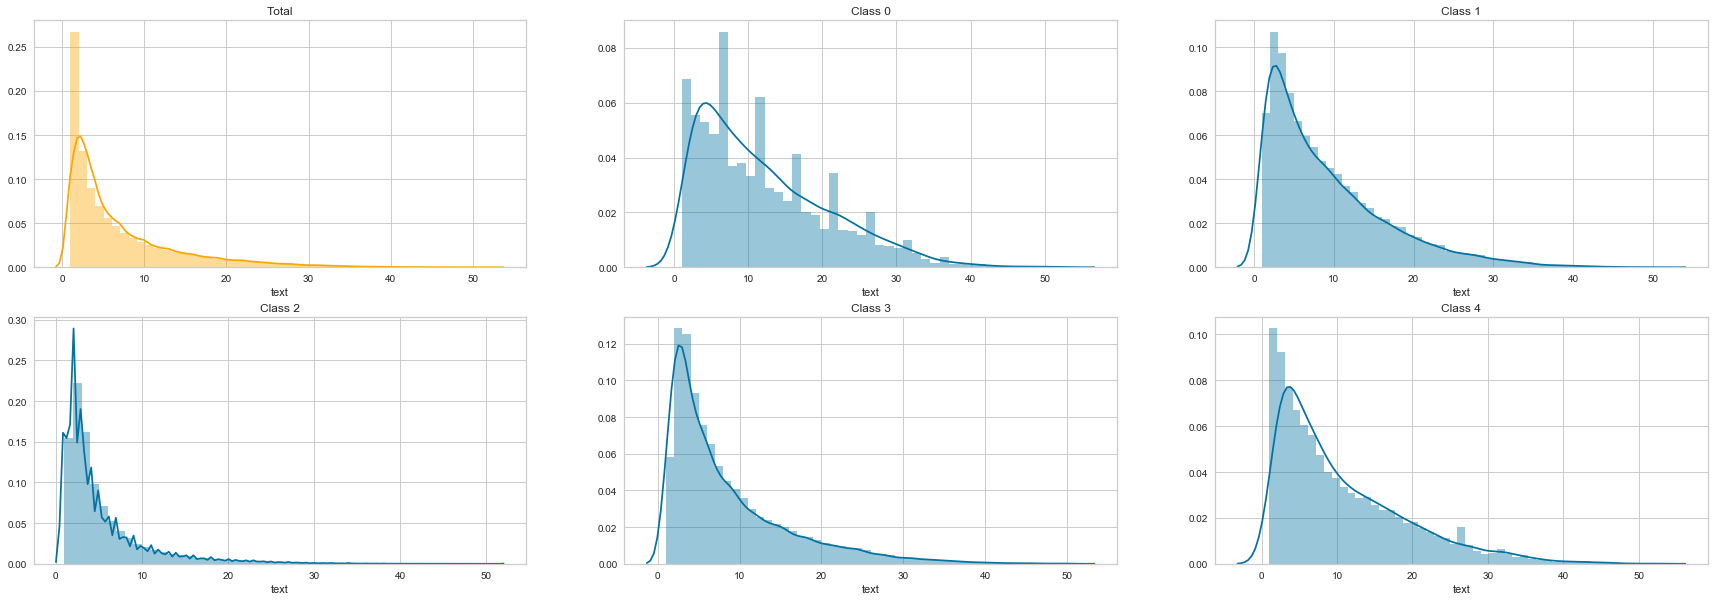

In [15]:
f, axes = plt.subplots(2, 3, figsize=(30, 10))

sns.distplot(phrase_word_count, ax=axes[0, 0], color="orange").set_title("Total")
sns.distplot(class0_word_count, ax=axes[0, 1]).set_title("Class 0")
sns.distplot(class1_word_count, ax=axes[0, 2]).set_title("Class 1")
sns.distplot(class2_word_count, ax=axes[1, 0]).set_title("Class 2")
sns.distplot(class3_word_count, ax=axes[1, 1]).set_title("Class 3")
sns.distplot(class4_word_count, ax=axes[1, 2]).set_title("Class 4")

Observando os gráficos e a tabela algumas informações podem ser extraídas:

* __Frases Pequenas__: Em geral temos muitas frases pequenas, isso pode ser observado através da distribuição cauda longa nos gráficos
* __Tamanho Máximo__: A quantidade de palavras máxima/frase é quase constante em todos as classes
* __Intensidade do sentimento__: Há uma correlação onde quanto maior a intensidade maior a tendência de se encontrar frases maiores. Isso pode ser visto que temos uma área maior nas caudas a medida que elas vão sendo mais extremas

#### Relação da quantidade de palavras x sentença 

Aqui a idéia é entender a relação da quantidade de palavras e as sentenças

In [18]:
def words_sentence_count(df):
    
    df_dict = {}

    for x in list(set(df.index.get_level_values(1))):
        words2dlist = [y.split(" ") for y in df.xs(x, level=1).text]   # Creates a list of lists from splited phrases
        flattenlist = list(itertools.chain.from_iterable(words2dlist)) # flattens the list in a 1D array
        df_dict[x]  = len(flattenlist)
    
    return pd.Series(df_dict)

In [19]:
word_sentence_count = words_sentence_count(reviews_df)

class0_word_sentence_count = words_sentence_count(class0_corpus)
class1_word_sentence_count = words_sentence_count(class1_corpus)
class2_word_sentence_count = words_sentence_count(class2_corpus)
class3_word_sentence_count = words_sentence_count(class3_corpus)
class4_word_sentence_count = words_sentence_count(class4_corpus)

pd.concat([word_sentence_count.describe(), class0_word_sentence_count.describe(), class1_word_sentence_count.describe(), class2_word_sentence_count.describe(), class3_word_sentence_count.describe(), class4_word_sentence_count.describe()], 
           axis=1, keys=["total", "class0", "class1", "class2", "class3", "class4"]).round(decimals=2)

,total,class0,class1,class2,class3,class4
count,8529.0,2609.00,6001.00,8115.00,6699.00,3123.00
mean,131.8,32.81,41.41,50.94,41.52,31.55
std,98.7,38.59,43.32,48.35,45.88,36.55
min,1.0,1.00,1.00,1.00,1.00,1.00
25%,56.0,9.00,10.00,17.00,9.00,7.00
50%,111.0,20.00,27.00,36.00,25.00,19.00
75%,185.0,43.00,58.00,70.00,59.00,42.00
max,751.0,362.00,351.00,400.00,376.00,408.00


Text(0.5,1,'Class 4')

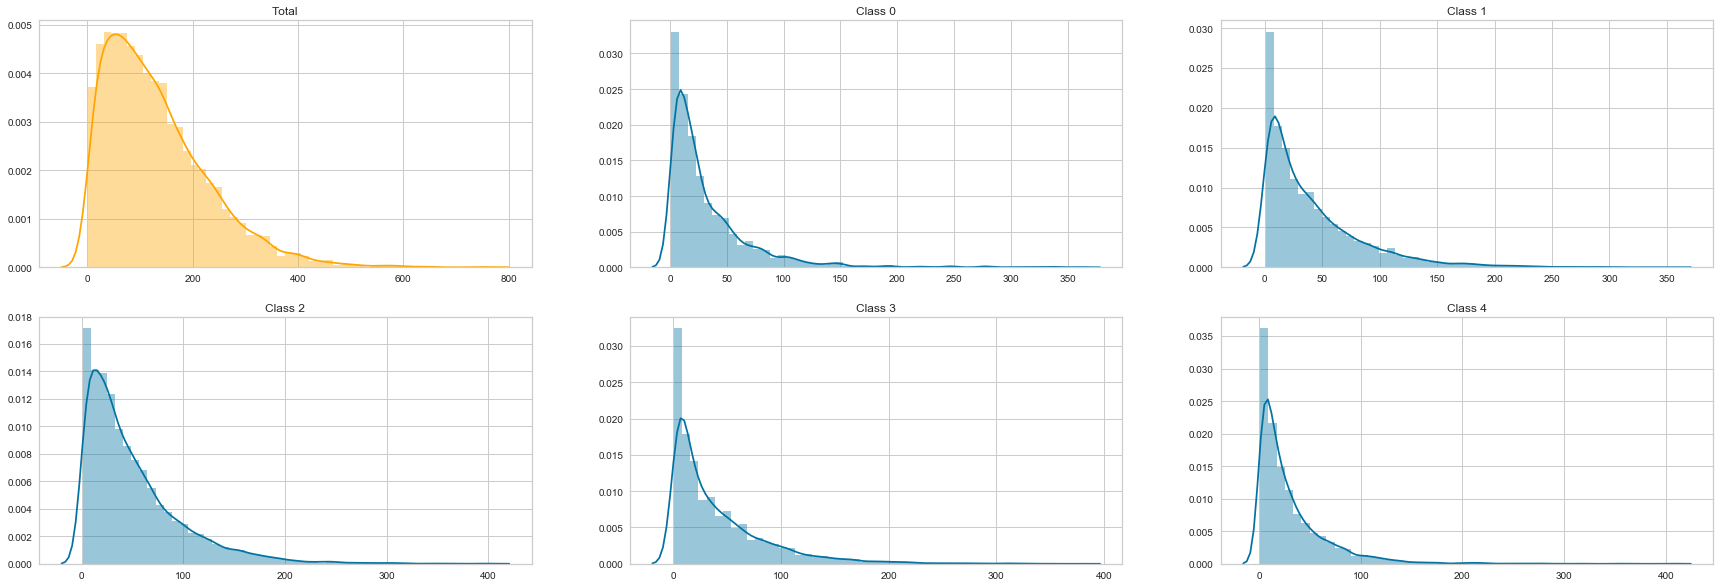

In [20]:
f, axes = plt.subplots(2, 3, figsize=(30, 10))

sns.distplot(word_sentence_count, ax=axes[0, 0], color="orange").set_title("Total")
sns.distplot(class0_word_sentence_count, ax=axes[0, 1]).set_title("Class 0")
sns.distplot(class1_word_sentence_count, ax=axes[0, 2]).set_title("Class 1")
sns.distplot(class2_word_sentence_count, ax=axes[1, 0]).set_title("Class 2")
sns.distplot(class3_word_sentence_count, ax=axes[1, 1]).set_title("Class 3")
sns.distplot(class4_word_sentence_count, ax=axes[1, 2]).set_title("Class 4")

Observando os dados acima temos que a distribuição de quantidade de palavras extraídas por sentença nas frases é aparentemente proximas entre as classes não-neutras. Observando o gráfico amarelo é possivel notar também que temos muitas sentenças menores que 100 palavras.

### Frequência das palavras

Após a análise quantitativa das palavras em relação as frases. O objetivo aqui é analisar a frequencia das palavras no banco e em relação as classes. Isso é importante para tentar entender quais palavras afetam mais ou menos a classificação.

Para atingir esse objetivo toda a análise é feita a partir de um pré-processamento como seguido como descrito abaixo:

* Todas as frases são divididas em tokens utilizando o [word_tokenize](https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.punkt) da biblioteca nltk, esse tokenizer flexibiliza a aparição de pontuação já que ela é diferencial na diferenciação entre classes
* Os tokens são passados pelo WordNetLemmatizer que busca reduzir os tokens as suas formas mais "puras" (desflexionadas), o objetivo aqui é diminuir a quantidade de features
* Somente tokens de tamanho 1 (1-gram) são utilizados
* Tokens compostos somente de números são removidas já que elas não fazem tanta diferença na classificação de sentimentos
* Letras acentuadas são transformadas nas suas formas mais simples (i.e. sem acentuação)

Para facilitar essa informação, as palavras são plotadas de acordo com a função definida abaixo.

In [6]:
def plot_word_frequency(X, vectorizer, n=50, figsize=(25, 5), title=None):
    plt.figure(figsize=figsize)
    a = pd.Series({x:y for x, y in zip(vectorizer.get_feature_names(), X.toarray().sum(axis=0))}).to_frame("count").sort_values("count", ascending=False)[:n]
    sns.barplot(x=a.index, y='count', data=a).set_title(title)

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t).strip() for t in word_tokenize(articles) if re.search("[0-9]", t, flags=0) == None]

Para simplificar um pouco mais essa análise as classes 0 e 1 serão tratados como sentimento negativos, a classe 2 como neutro e as classes 3 e 4 como sentimento positivo.

In [23]:
negative_df = reviews_df.query("sentiment == 0 or sentiment == 1")
neutral_df  = reviews_df.query("sentiment == 2")
positive_df = reviews_df.query("sentiment == 3 or sentiment == 4")

Tokenizando os textos temos

In [24]:
total_vectorizer    = CountVectorizer(strip_accents="unicode", lowercase=True, tokenizer=LemmaTokenizer(), analyzer="word")
positive_vectorizer = CountVectorizer(strip_accents="unicode", lowercase=True, tokenizer=LemmaTokenizer(), analyzer="word")
neutral_vectorizer  = CountVectorizer(strip_accents="unicode", lowercase=True, tokenizer=LemmaTokenizer(), analyzer="word")
negative_vectorizer = CountVectorizer(strip_accents="unicode", lowercase=True, tokenizer=LemmaTokenizer(), analyzer="word")

In [25]:
wordsfreqvec_total    = total_vectorizer.fit_transform(reviews_df.text)
wordsfreqvec_neutral  = positive_vectorizer.fit_transform(neutral_df.text)
wordsfreqvec_positive = neutral_vectorizer.fit_transform(positive_df.text)
wordsfreqvec_negative = negative_vectorizer.fit_transform(negative_df.text)

In [26]:
negative_features = negative_vectorizer.get_feature_names()
positive_features = positive_vectorizer.get_feature_names()
neutral_features  = neutral_vectorizer.get_feature_names()

#### Todas as classes

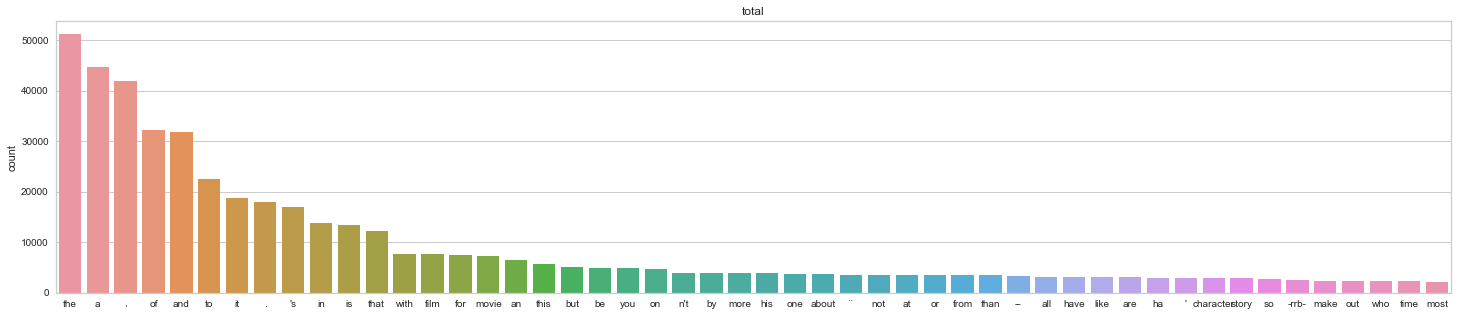

In [28]:
plot_word_frequency(wordsfreqvec_total, total_vectorizer, figsize=(25, 5), title="total")

#### Classe Negativa

Quantidade de palavras unicas no conjunto em relação aos positivos:  322 (e.g. ['prechewed', 'audacious-impossible', 'laziest', 'vile', 'tumbleweed'])
Quantidade de palavras unicas no conjunto em relação aos neutros:    3175 (e.g. ['idiotic', 'dissecting', 'veered', 'fleeing', 'unnamed'])



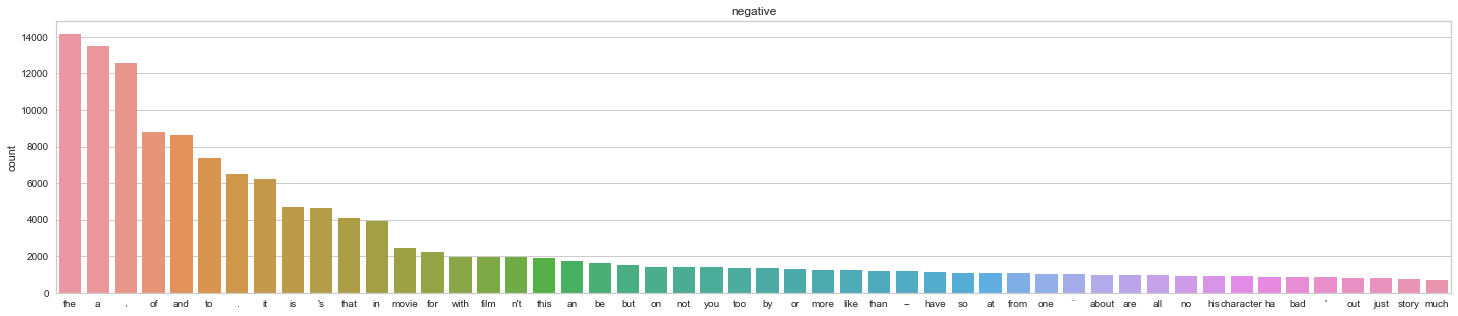

In [29]:
diff_positive = list(set(negative_features) - set(positive_features))
diff_neutral  = list(set(negative_features) - set(neutral_features))

print("Quantidade de palavras unicas no conjunto em relação aos positivos:  %s (e.g. %s)" %(len(diff_positive), random.sample(diff_positive, 5)))
print("Quantidade de palavras unicas no conjunto em relação aos neutros:    %s (e.g. %s)" %(len(diff_neutral),  random.sample(diff_neutral, 5)))
print()

plot_word_frequency(wordsfreqvec_negative, negative_vectorizer, figsize=(25, 5), title="negative")

#### Classe Positiva

Quantidade de palavras unicas no conjunto em relação aos negativos:  3284 (e.g. ['carter', 'nighttime', 'duty', 'twilight', 'smartest'])
Quantidade de palavras unicas no conjunto em relação aos neutros:    3179 (e.g. ['squirm-inducing', 'decter', 'sprinkled', 'soberly', 'persnickety'])



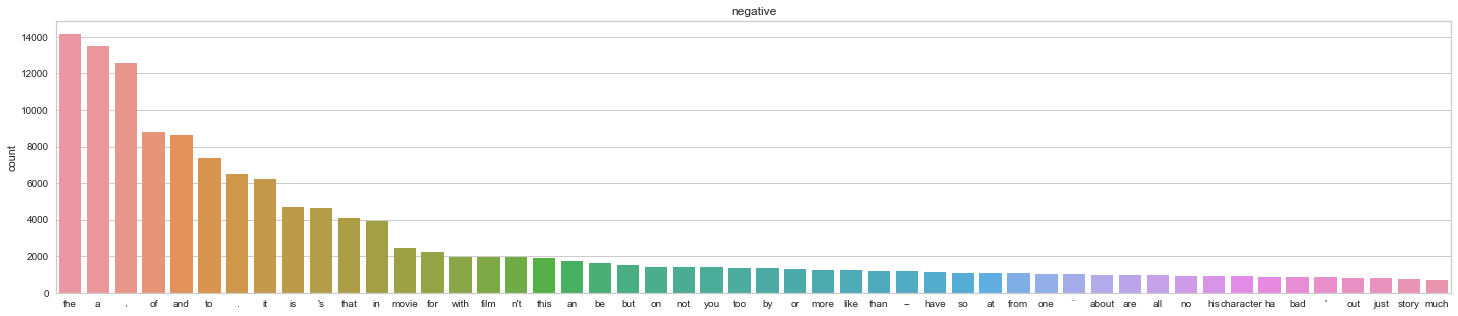

In [30]:
diff_negative = list(set(positive_features) - set(negative_features))
diff_neutral  = list(set(positive_features) - set(neutral_features))

print("Quantidade de palavras unicas no conjunto em relação aos negativos:  %s (e.g. %s)" %(len(diff_negative), random.sample(diff_negative, 5)))
print("Quantidade de palavras unicas no conjunto em relação aos neutros:    %s (e.g. %s)" %(len(diff_neutral),  random.sample(diff_neutral, 5)))
print()

plot_word_frequency(wordsfreqvec_negative, negative_vectorizer, figsize=(25, 5), title="negative")

#### Classe Neutra

Quantidade de palavras unicas no conjunto em relação aos positivos:  3248 (e.g. ['huge-screen', 'diction', 'sportsman', 'reopens', 'stunning'])
Quantidade de palavras unicas no conjunto em relação aos negativos:  290 (e.g. ['cheerfully', 'metaphysical', 'well-contructed', 'vibrance', 'enlivens'])



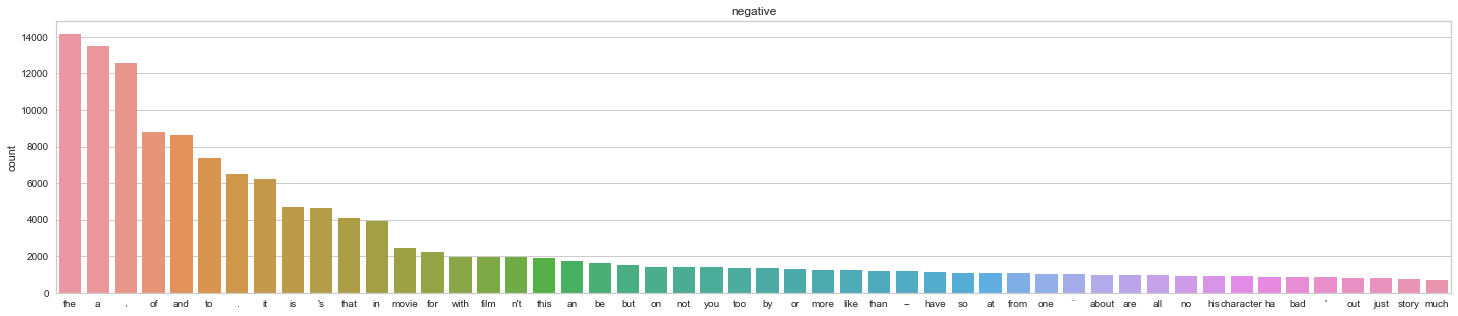

In [31]:
diff_negative = list(set(neutral_features) - set(negative_features))
diff_positive  = list(set(neutral_features) - set(positive_features))

print("Quantidade de palavras unicas no conjunto em relação aos positivos:  %s (e.g. %s)" %(len(diff_negative), random.sample(diff_negative, 5)))
print("Quantidade de palavras unicas no conjunto em relação aos negativos:  %s (e.g. %s)" %(len(diff_positive), random.sample(diff_positive, 5)))
print()

plot_word_frequency(wordsfreqvec_negative, negative_vectorizer, figsize=(25, 5), title="negative")

Acima é possível tirar algumas conclusões

* Como esperado stop words são as palavras mais frequentes em todos os casos
* Há Muitas palavras em comum entre as classes
* Em relação as palavras únicas não temos uma grande quantidade de palavras que possam diferenciar as classes, isso ainda é um pouco mais agravente para o caso da classe dos negativos (entre neutros e positivos)

# Modelagem

Baseado nas informações extraídas até aqui, algumas hipoteses vão direcionar essa modelagem:

* A remoção de stop words e simbolos pode diminuir muito a performance dos modelos, já que muitas das frases são compostas por elas.
* Uso de 1-grams podem não ajudar muito a análise já que muitos símbolos e stop words vão aparecer e eles tem uma representação em todos as classes
* As classes negativas talvez tenham um maior problema para ser diferenciadas
* Desbalanceamento talvez não afete muito a performance já que os sentimentos apresentam frases maiores, isso aliado ao uso de bi ou tri-grams (que dão mais contexto) talvez ajudem

## Pré-Processamento

Portanto a abordagema  ser seguida será a utilização do algoritmo de _TF-IDF com 1-gram e 2-gram_ para aumentar o contexto do modelo e dar menor peso para as palavras mais frequentes. A tokenização será como utilizada na análise exploratória, isto é, sem numeros, símbolos mais flexíveis e lematização.

In [7]:
tfidf_2gram = TfidfVectorizer(strip_accents="unicode", lowercase=True, tokenizer=LemmaTokenizer(), analyzer="word", ngram_range=(1, 2))

## Dataset Split

Para evitar viés na avaliação, utilizaremos uma separação dos dados em 70/30 para treinamento e validação.

In [8]:
X = reviews_df.text
y = reviews_df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, shuffle=True, stratify=y)

## Experimentos

Os experimentos a seguir são feitos utilizado um 5-fold cross validation utilizando um grid-search nos parâmetros definidos em cada um dos modelos. Esses passos são implementados utilizando pipelines do scikit-learn. A escolha por um grid search é feita somente devido ao tempo necessário ser um pouco menor caso comparado a utilização de um random search (mesmo que o ultimo tenha em geral resultados melhores). A escolha dos hiperparâmetros é feita baseado no [post](http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/) feito por Abhishek Thakur para o blog oficial do kaggle.

In [12]:
# Save Results on disk

def save_gc_results(X_train, X_test, y_test, tfidf_vec, gscv, train_path, results_path):
    
    # Saving Training Results
    train_path.mkdir(parents=True, exist_ok=True)
    pd.DataFrame(gscv.cv_results_).to_csv(train_path / "trainvalid.csv")
    dump(gscv.best_estimator_, train_path / 'bestmodel.joblib') 
    
    # Evaluating Test Scores
    tfidf_vec.fit(X_train)
    test_transformed = tfidf_vec.transform(X_test)
    
    best_model_predictions = gscv.best_estimator_.predict(X_test)
    
    prf_scores = precision_recall_fscore_support(y_test, best_model_predictions, average="weighted")
    acc_scores = accuracy_score(y_test, best_model_predictions)
    
    # Saving Test Scores
    test_scores = pd.Series([acc_scores, prf_scores[0], prf_scores[1], prf_scores[2]], index=["accuracy", "precision", "recall", "f1"])
    
    if (results_path / "test_results.csv").exists() == False:
        test_scores.to_frame().transpose().to_csv(results_path / "test_results.csv")
    else:
        pd.read_csv(results_path / "test_results.csv", index_col=0).append(test_scores, ignore_index=True).to_csv(results_path / "test_results.csv")
    
    # Printing Results
    print("Validation Score: %s" %gscv.best_score_)
    
    print()
    print("Test Scores:")
    print(test_scores)
    print()

### Experimento 01: Logistic Regression

O primeiro experimento é feito utilizando uma regressão logística. Esse modelo foi escolhido devido ao seu uso em larga escala como modelo base em experimentos de machine learning além de ser muito utilzado em aplicações de NLP. Esse modelo será usado como baseline para o treinamento dos outros.

In [7]:
lr_params = {
    "lr__C":       [0.001, 0.01, 0.1, 1, 10, 100],
    "lr__solver":  ["newton-cg", "sag", "saga", "lbfgs"]
}

model_lr = LogisticRegression(random_state=RANDOM_STATE, penalty="l2", multi_class="multinomial")

In [13]:
pipe_lr_tf_2 = Pipeline([("TFIDF2", tfidf_2gram), ("lr", model_lr)])
gscv_lr_tf_2 = GridSearchCV(pipe_lr_tf_2, lr_params, cv=5, scoring=["accuracy", "f1_weighted", "precision_weighted", "recall_weighted"], n_jobs=4, refit="f1_weighted", verbose=1, return_train_score=True)
gscv_lr_tf_2.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 19.8min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 58.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('TFIDF2', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True..., penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100], 'lr__solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=True,
       scoring=['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'],
       verbose=1)

In [ ]:
# Test Set Evaluation and saving
EXP01PATH    = REPORTPATH / "exp01"
save_gc_results(X_train, X_test, y_test, tfidf_2gram, gscv_lr_tf_2, EXP01PATH, REPORTPATH)

Validation Score: 0.6285613786491036

Test Scores:
accuracy     0.650498
precision    0.639193
recall       0.650498
f1           0.641762
dtype: float64



7

### Experimento 02: Multinomial Naive Bayes

O segundo modelo escolhido é o Naive Bayes Multinomial. Em geral, o algoritmo Naive Bayes é um classico em aplicações de NLP como detecção de spam. A versão multinomial foi escolhida especialmente por ser uma melhoria do gaussiano que ainda leva em conta o desbalanceamento dos dados.

In [18]:
nb_params = {
    "nb__alpha":  [0, 1, 2, 3, 4, 5],
}

model_nb = MultinomialNB()

In [21]:
pipe_nb_tf_2 = Pipeline([("TFIDF2", tfidf_2gram), ("nb", model_nb)])
gscv_nb_tf_2 = GridSearchCV(pipe_nb_tf_2, nb_params, cv=5, scoring=["accuracy", "f1_weighted", "precision_weighted", "recall_weighted"], n_jobs=4, refit="f1_weighted", verbose=2, return_train_score=True)
gscv_nb_tf_2.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 13.5min finished
C:\Miniconda3\envs\desafiointelivix\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('TFIDF2', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...use_idf=True, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'nb__alpha': [0, 1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=True,
       scoring=['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'],
       verbose=2)

In [22]:
EXP02PATH    = REPORTPATH / "exp02"
save_gc_results(X_train, X_test, y_test, tfidf_2gram, gscv_nb_tf_2, EXP02PATH, REPORTPATH)

Validation Score: 0.5757219724898847

Test Scores:
accuracy     0.591717
precision    0.605144
recall       0.591717
f1           0.597032
dtype: float64



NameError: name 'gc' is not defined

### Experiemento 03: Random Forest

Por último temos o uso do Random Forest. Esse algoritmo utiliza da técnica de bagging que agrupa diversas arvores de decisão aleatoriamente em subconjutnos dos dados. Esse algoritmo tem no geral uma boa performace em diversos tipos de problemas e foi muito utilizado em competições do kaggle obtendo os melhores scores.

In [14]:
rf_params = {
    "rf__n_estimators":      [300, 500, 800],
    "rf__max_depth":         [15, 30, 60, 100],
}

model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

In [15]:
pipe_rf_tf_2 = Pipeline([("TFIDF2", tfidf_2gram), ("rf", model_rf)])
gscv_rf_tf_2 = GridSearchCV(pipe_rf_tf_2, rf_params, cv=5, scoring=["accuracy", "f1_weighted", "precision_weighted", "recall_weighted"], n_jobs=4, refit="f1_weighted", verbose=2, return_train_score=True)
gscv_rf_tf_2.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 39.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 175.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('TFIDF2', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...rs='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'rf__n_estimators': [300, 500, 800], 'rf__max_depth': [15, 30, 60, 100]},
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=True,
       scoring=['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'],
       verbose=2)

In [16]:
EXP03PATH    = REPORTPATH / "exp03"
save_gc_results(X_train, X_test, y_test, tfidf_2gram, gscv_rf_tf_2, EXP03PATH, REPORTPATH)

Validation Score: 0.4691695428309017

Test Scores:
accuracy     0.564655
precision    0.577381
recall       0.564655
f1           0.475319
dtype: float64



# Análise dos Resultados

Finalmente, é important analisar os resultados obtidos nos modelos utilizados para a solução do problema. Para simplificar o código a função abaixo foi criada para fazer o report dos dados utilizados abaixo.

In [25]:
def report_results(exp_name, X_train, X_test, y_train, y_test):
    
    # Best Results
    best_results = pd.read_csv(REPORTPATH / exp_name / "trainvalid.csv")
    best_results = best_results.reindex(sorted(best_results.columns), axis=1).sort_values("rank_test_f1_weighted", axis=0)
    
    df_dict = {}
    for mean, std in zip(best_results.columns[3:10], best_results.columns[60:]):
        df_dict[mean] = []
        for x, y in zip(best_results[mean], best_results[std]):
            df_dict[mean].append((str(round(x, 3)) + "±" +  str(round(y, 3))))
            
    best_results_final = pd.DataFrame(df_dict)
            
    # Evaluation
    tfidf_vec = TfidfVectorizer(strip_accents="unicode", lowercase=True, tokenizer=LemmaTokenizer(), analyzer="word", ngram_range=(1, 2))
    tfidf_vec.fit(X_train)
    test_transformed = tfidf_vec.transform(X_test)
    
    best_model_predictions = load(REPORTPATH / exp_name / "bestmodel.joblib").predict(X_test)
    
    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, best_model_predictions, labels=[0, 1, 2, 3, 4])
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    conf_mat = pd.DataFrame(conf_mat, index = [i for i in "01234"], columns = [i for i in "01234"])
    
    # Wrong Predicted Elements
    index = 0
    wrong_indexes = []
    
    for tst, prd in zip(y_test, best_model_predictions):
        if tst != prd: wrong_indexes.append(index)
        index += 1
        
    wrong_predictions = X_test.iloc[wrong_indexes]
        
    return best_results_final, wrong_predictions, conf_mat

Gerando os resultados para a análise

In [26]:
results_report_exp01 = report_results("exp01", X_train, X_test, y_train, y_test)
results_report_exp02 = report_results("exp02", X_train, X_test, y_train, y_test)
results_report_exp03 = report_results("exp03", X_train, X_test, y_train, y_test)

## Conjunto de treinamento e validação

A tabela abaixo mostra os 5 melhores resultados para cada um dos experimentos com seus devidos desvios-padrões.

In [27]:
N_ROWS = 5
e1 = results_report_exp01[0].head(N_ROWS).set_index([["Exp 01"] * N_ROWS, results_report_exp01[0].head(N_ROWS).index])
e2 = results_report_exp02[0].head(N_ROWS).set_index([["Exp 02"] * N_ROWS, results_report_exp02[0].head(N_ROWS).index])
e3 = results_report_exp03[0].head(N_ROWS).set_index([["Exp 03"] * N_ROWS, results_report_exp03[0].head(N_ROWS).index])

In [28]:
pd.concat([e1, e2, e3])

mean_test_accuracy mean_test_f1_weighted  \
Exp 01 0        0.638±0.003           0.629±0.003   
       1        0.638±0.003           0.629±0.003   
       2        0.638±0.003           0.629±0.003   
       3        0.639±0.004           0.627±0.003   
       4        0.632±0.006           0.625±0.005   
Exp 02 0        0.569±0.005           0.576±0.005   
       1        0.592±0.002           0.529±0.005   
       2        0.552±0.002           0.442±0.025   
       3          0.531±0.0           0.394±0.003   
       4        0.521±0.001            0.37±0.019   
Exp 03 0        0.561±0.001           0.469±0.002   
       1        0.561±0.001           0.469±0.002   
       2        0.561±0.001           0.468±0.002   
       3        0.532±0.001           0.402±0.002   
       4        0.532±0.001           0.402±0.001   

         mean_test_precision_weighted mean_test_recall_weighted  \
Exp 01 0                  0.625±0.003               0.638±0.003   
       1                  0.625±0.003               0.638±0.003   
       2                  0.625±0.003               0.638±0.003   
       3                  0.625±0.004               0.639±0.004   
       4                  0.622±0.005               0.632±0.006   
Exp 02 0                  0.586±0.005               0.569±0.001   
       1                  0.594±0.002               0.592±0.001   
       2                  0.523±0.001               0.552±0.001   
       3                    0.474±0.0               0.531±0.001   
       4                  0.441±0.001                 0.521±0.0   
Exp 03 0                  0.571±0.005               0.561±0.001   
       1                  0.571±0.004               0.561±0.001   
       2                  0.571±0.005               0.561±0.001   
       3                  0.571±0.007               0.532±0.001   
       4                   0.57±0.007               0.532±0.001   

         mean_train_accuracy mean_train_f1_weighted  \
Exp 01 0           0.913±0.0              0.912±0.0   
       1           0.913±0.0              0.912±0.0   
       2           0.913±0.0              0.912±0.0   
       3         0.796±0.007            0.791±0.007   
       4         0.817±0.005            0.815±0.005   
Exp 02 0          0.81±0.001            0.811±0.001   
       1         0.681±0.001             0.63±0.001   
       2         0.593±0.002            0.499±0.019   
       3         0.551±0.001            0.427±0.004   
       4          0.53±0.001            0.388±0.004   
Exp 03 0         0.675±0.001            0.633±0.002   
       1         0.675±0.001            0.633±0.002   
       2         0.675±0.001            0.633±0.001   
       3         0.581±0.001            0.486±0.001   
       4         0.581±0.001            0.485±0.001   

         mean_train_precision_weighted  
Exp 01 0                     0.912±0.0  
       1                     0.912±0.0  
       2                     0.912±0.0  
       3                   0.793±0.007  
       4                   0.815±0.005  
Exp 02 0                   0.813±0.001  
       1                   0.719±0.001  
       2                   0.667±0.001  
       3                   0.554±0.001  
       4                      0.54±0.0  
Exp 03 0                     0.801±0.0  
       1                   0.801±0.001  
       2                     0.801±0.0  
       3                   0.764±0.001  
       4                   0.764±0.001

Analisando a tabela acima temos que o experimento 01 utilizando regressáo logistica teve resultado superior tanto no treinamento quanto no conjunto de validação. Além disso, as 3 primeiras configurações desse modelo tiveram uma performance semelhante.

## Conjunto de teste

Agora é feita a análise do conjunto de testes 

### Comparação das métricas

In [43]:
test_results = pd.read_csv(REPORTPATH/"test_results.csv")
test_results_melted = test_results.rename(columns={'Unnamed: 0':'Experiment'})
test_results_melted = test_results_melted.melt(id_vars=["Experiment"], value_vars=["accuracy", "precision", "recall", "f1"])

In [44]:
test_results = test_results.drop('Unnamed: 0', axis=1)
test_results

,accuracy,precision,recall,f1
0,0.650498,0.639193,0.650498,0.641762
1,0.591717,0.605144,0.591717,0.597032
2,0.564655,0.577381,0.564655,0.475319


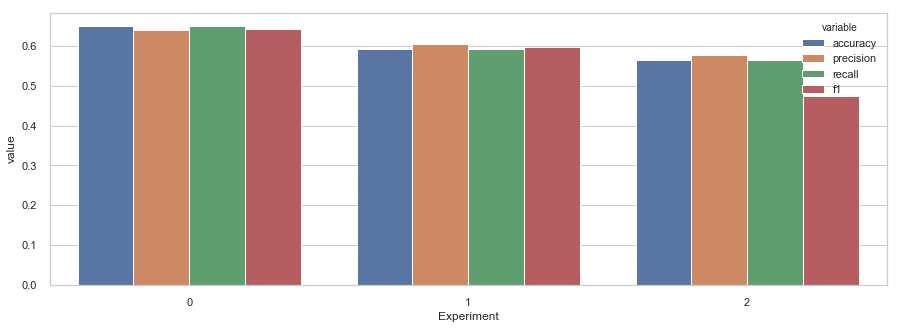

In [45]:
plt.figure(figsize=(15, 5))

sns.set(style="whitegrid")
sns.barplot(x="Experiment", y="value", hue="variable", data=test_results_melted)

Como pode ser visto no gráfico acima, é possível observar também a superioridade do modelo de regressão logistica no conjunto de testes

### Matriz de Confusão

Text(0.5,1,'Experiment 03')

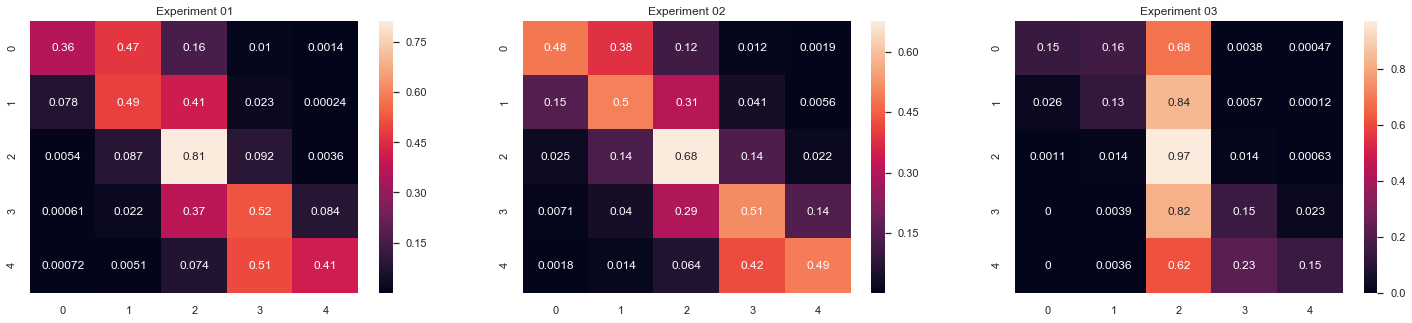

In [30]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))

sns.heatmap(results_report_exp01[2], annot=True, ax=axes[0]).set_title("Experiment 01")
sns.heatmap(results_report_exp02[2], annot=True, ax=axes[1]).set_title("Experiment 02")
sns.heatmap(results_report_exp03[2], annot=True, ax=axes[2]).set_title("Experiment 03")

Através das matrizes de confusão (normalizadas por suporte) é possível notar que o grande diferencial entre todos os modelos é no reconhecimento da classe das frases neutras, o que é esperado devido ao grau de desbalanceamento. Porém há outros pontos importantes aqui em relação ao desbalanceamento: Todos os modelos no geral tiveram um grau maior taxa de falsos positivos e negativos na classe 2. O que mostra como os algoritmos sofreram o viés do desbalanceamento. Cabe destacar o random forest que teve quase 100% de acerto da classe majoritaria (superando o experimento 01) mas preveu que quase todas os elementos eram da classe 2, ou seja, ele foi o mais impactado pelo desbalanceamento.

Além disso, apesar de não ter tido o melhor desempenho, o Multinomial Naive Bayes que foi criado para diminuir os problemas do desbalanceamento, teve uma taxa de acerto um pouco melhor das outras classes em comparação da regressão linear.

### Elementos mais problemáticos

A idéia dessa análise é tentar descobrir se há alguma relação entre os elementos que tiveram problemas de classificação nos 3 modelos. O objetivo é tentar determinar se existe alguma caractéristica em comum que possa estar dificultando a performance dos modelos e uma possível forma de eliminar esse problema

In [31]:
el_exp01 = set(results_report_exp01[1].values)
el_exp02 = set(results_report_exp02[1].values)
el_exp03 = set(results_report_exp03[1].values)

common_elements = list(el_exp01 & el_exp02 & el_exp03)

print("No total temos %s frases incorretamente classificadas nos 3 conjuntos, alguns exemplos são:" %len(common_elements)) 

No total temos 9869 frases incorretamente classificadas nos 3 conjuntos, alguns exemplos são:


In [32]:
random.sample(common_elements, 50)

['undernourished',
 'really work',
 'unexplainable pain',
 "it 's funny",
 'high-concept films',
 "It 's depressing to see how far Herzog has fallen .",
 'casts its spooky net',
 'watching monkeys flinging their feces at you',
 'approaches the endeavor with a shocking lack of irony',
 "overcomes the script 's flaws and envelops the audience in his character 's anguish , anger and frustration",
 "are n't your bailiwick",
 'do , too little time to do it in',
 'huge gap',
 "have you swinging from the trees hooting it 's praises",
 'P -RRB-',
 'Consider the film a celluloid litmus test for the intellectual and emotional pedigree of your date and a giant step backward for a director I admire',
 'intended for the home video market',
 "is no doubt that Krawczyk deserves a huge amount of the credit for the film 's thoroughly winning tone .",
 'with two fine , nuanced lead performances',
 "Nothing about the film -- with the possible exception of Elizabeth Hurley 's breasts -- is authentic .",
 

Como pode ser visto acima, quase 10000 frases foram mal classificadas em todos os modelos, isso representa 6% do conjunto de dados total e 21% do conjunto de testes. Analisando alguns exemplos das frases não é possível encontrar alguma relação entre as frases, porém para afirmar algo seria necessária uma análise mais aprofundada dos casos.

# Conclusão

Foi possível encontrar um modelo interessante para fazer a análise de sentimentos no banco de dados utilizado para uma tarefa complicada. No geral, o desbalanceamento atrapalhou sim a performance dos modelos. Outro fator importante que pode ter impactado a performance foi a pouca variação dos hiperparametros (principalmente no random forest). Alguns passos futuros poderiam ser tomados para atingir uma performance melhor. No pré-processamento:

* Explorar o impacto de 3-grams
* Uso de outros lemmatizers
* Aplicar novas representações como word2vec, Glove
* Fazer oversampling dos dados

Na fase de modelagem:

* Utilzar redes neurais e/ou modelos de deep learning como ConvNets, RNNs e LTSMs
* Utilizar random search no lugar do grid-search (ou pelo menos adicionar mais hiperparametros)

Na avaliação dos modelos:

* 10-Fold Cross validation para ter uma avaliação mais robusta
* Aplicação de teste estatístico de hipoteses para comparar os modelos